# Intro

The purpose of this code is to look at relationships between stock data and the sentiment scores of articles regarding said stocks. We will use sentiment scores generated by VADER and FinVADER. The stocks are sorted by data+ticker, or date+sector (Tech, Health, Finance). The naive mean is taken between the sentiment scores of all articles on a particular stock in the same day. 

The goal is to provide plots of these sentiment scores against the closing stock prices up to a week afer said score. 

# Packages


In [1]:
!pip install finvader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from finvader import finvader as fv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sultanitw/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here I mess around with the csv files to look for possible inconsistencies. I also test out FinVADER compound sentiment scores versus those from regular VADER

In [3]:
df = pd.read_csv('../data/news_data_2019_2024_complete.csv')
print(df.iloc[0])
apple = pd.read_csv('../Stock_data/Apple_stock.csv')
apple.iloc[10]
txt= df['Headline'].iloc[0] +' '+ df['Text'].iloc[0]
print(txt)
print(fv(text = txt, use_henry= True, use_sentibignomics=True, indicator='compound'))
print(fv(text = txt, use_henry= True, use_sentibignomics=False, indicator='compound'))
#  fv(text = txt, use_henry= False, use_sentibignomics=False, indicator='compound')
print(fv(text = txt, use_henry= False, use_sentibignomics=True, indicator='compound'))
analyzer = SentimentIntensityAnalyzer()
print(analyzer.polarity_scores(txt))


Unnamed: 0                                                       0
Date & Time                              2019-03-15 10:46:42+00:00
Date                                                    2019-03-15
Time                                                      10:46:42
Ticker                                                         WFC
Sector                                                     Finance
Source                                             The Motley Fool
sentiment_neg                                                  0.0
sentiment_neu                                                0.931
sentiment_pos                                                0.069
sentiment_tot                                                 0.25
Headline         Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...
Text             We learned this week that the scandal-plagued ...
URL              https://www.fool.com/investing/2019/03/14/did-...
Name: 0, dtype: object
Did Wells Fargo CEO Tim Sloan Earn His 

# DataFrames

Now we want to create the necesssary dataframes that we will be working with

First, we need to incorporate the FinVader sentiment scores of our articles. The following function does this for us, which we then apply to our dataframe to create a new column for FinVader scores.

In [4]:
def fin_sentiment_score(headline:str, abstract:str):
    txt = headline + ' ' + abstract
    return fv(text = txt, use_henry= True, use_sentibignomics=True, indicator='compound')


In [5]:
df['finvader'] = df.apply(lambda x: fin_sentiment_score(x['Headline'], x['Text']), axis = 1)


Now we group our sentiment scores by date+ticker and date+sector. The following dataframes are created by taking the naive mean on these groups. 

In [6]:
df.drop(labels = ['Unnamed: 0', 'Date & Time', 'sentiment_neg', 'sentiment_pos', 'sentiment_neu'], axis = 1)
df_ticker = df.groupby(['Date', 'Ticker'])[['sentiment_tot', 'finvader']].mean().reset_index()
df_sector = df.groupby(['Date', 'Sector'])[['sentiment_tot', 'finvader']].mean().reset_index()
df_ticker.head()


,Date,Ticker,sentiment_tot,finvader
0,2019-03-15,AAPL,0.491367,0.293033
1,2019-03-15,AMZN,0.506950,0.523483
2,2019-03-15,BAC,-0.536700,0.012900
3,2019-03-15,GOOGL,0.087100,0.001700
4,2019-03-15,JPM,0.226300,0.046400


In [7]:
df_ticker['Date'] = pd.to_datetime(df_ticker['Date'])
df_sector['Date']= pd.to_datetime(df_sector['Date'])
df_ticker.set_index('Date', inplace = True)
df_sector.set_index('Date', inplace = True)
df_ticker.head()

,Ticker,sentiment_tot,finvader
Date,,,
2019-03-15,AAPL,0.491367,0.293033
2019-03-15,AMZN,0.506950,0.523483
2019-03-15,BAC,-0.536700,0.012900
2019-03-15,GOOGL,0.087100,0.001700
2019-03-15,JPM,0.226300,0.046400


Now let's look at our stock data. Ideally, we want to do this part for each of our 15 stocks. For brevity, we instead provide general code which is applied to our example stock (in this case AAPL). In actuality, we would want to incorporate the following data into a separate script, which can read in the csv file and the ticker/sector to create a graph. 

In [8]:
#Change csv file to be whatever stock you want
csv_file = '../Stock_data/Apple_stock.csv'
df_stock = pd.read_csv(csv_file)
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1279 non-null   object 
 1   Open          1279 non-null   float64
 2   High          1279 non-null   float64
 3   Low           1279 non-null   float64
 4   Close         1279 non-null   float64
 5   Volume        1279 non-null   int64  
 6   Dividends     1279 non-null   float64
 7   Stock Splits  1279 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 80.1+ KB


Let's convert our dates to the datetime objects and remember only the calendar date.

In [9]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format = '%Y-%m-%d %H:%M:%S%z', utc = True)
df_stock['Date'] = df_stock['Date'].apply(lambda x : x.date())
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace = True)
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-01,41.887973,42.097075,41.553888,42.053814,103544800,0.0,0.0
2019-03-04,42.226871,42.721989,41.813471,42.265327,109744800,0.0,0.0
2019-03-05,42.286956,42.301376,41.950465,42.188412,78949600,0.0,0.0
2019-03-06,41.981718,42.178806,41.806265,41.945667,83241600,0.0,0.0
2019-03-07,41.789428,41.926429,41.344785,41.460152,99185600,0.0,0.0


Now let's merge the stock and sentiment data along tickers. 

In [37]:
#Change ticker to match that of df_stock 
tick = 'AAPL'
df_all = pd.merge(df_stock, df_ticker[df_ticker['Ticker'] == tick], left_index= True, right_index=True, how = 'outer')


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader
Date,,,,,,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.488050,0.016700
2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.000000,0.155400
2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.008600,0.185033
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.412367,0.133467
2019-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,-0.003650,0.330900
...,...,...,...,...,...,...,...,...,...,...
2024-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.774850,0.228000
2024-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.067933,0.097233
2024-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.163250,-0.105500


# Graphing with Lags

Let's now take our merged dataframe and add in time lags to our sentiment score. We will first modify the stock prices to reflect percentage changes from the previous x amount of days. We then will graph our sentiment scores against this data. 

Some thoughts:

What stock prices do we use? Closing time/High/Low are all options. What statistic is most ideal for solving our question at hand? 

In [38]:
#NOTE: Don't run multiple times, or you will get multiple copies of lag columns
timeframe = np.arange(0, 8, 1)
# print(timeframe)
for i in timeframe:
    df_lag = df_stock['Open'][:len(df_stock)-i] / df_stock.shift(periods = -i)['Close'][:len(df_stock)-i] -1
    df_lag.rename(str(i) + " lag", inplace = True)
    # print(df_lag.head())
    df_all = pd.merge(df_all, df_lag, left_index = True, right_index = True, how = 'outer')
df_all.head()   

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-01,41.887973,42.097075,41.553888,42.053814,103544800.0,0.0,0.0,NaN,NaN,NaN,-0.003944,-0.008928,-0.007121,-0.001375,0.010319,0.007923,-0.025825,-0.036648
2019-03-04,42.226871,42.721989,41.813471,42.265327,109744800.0,0.0,0.0,NaN,NaN,NaN,-0.000910,0.000912,0.006704,0.018493,0.016078,-0.017943,-0.028854,-0.033130
2019-03-05,42.286956,42.301376,41.950465,42.188412,78949600.0,0.0,0.0,NaN,NaN,NaN,0.002336,0.008136,0.019942,0.017524,-0.016546,-0.027472,-0.031754,-0.042399
2019-03-06,41.981718,42.178806,41.806265,41.945667,83241600.0,0.0,0.0,NaN,NaN,NaN,0.000859,0.012580,0.010179,-0.023644,-0.034492,-0.038743,-0.049311,-0.061519
2019-03-07,41.789428,41.926429,41.344785,41.460152,99185600.0,0.0,0.0,NaN,NaN,NaN,0.007942,0.005552,-0.028116,-0.038914,-0.043146,-0.053666,-0.065818,-0.075258


The resulting dataframe df_all contains all the stock information, the sentiment scores (both vanilla and financial VADER), and the percentage of stock change according to i-days (e.g. i -lag is the percentage change from the opening price on the index date to the closing price i-days later)

Note that there are days when the stock market isn't open (e.g. weekends). On such days, all our stock data are NANs, but we may still have sentiment scores since articles are published over the weekend. There are two ways I would suggest dealing with this:

1. The sentiment scores on days when the market is closed should be incorporated into the next open day of the market (i.e. reaverage with those days). I think this is probably ideal, but I would have to rewrite some earlier code. 

2. Backfill the stock scores. That is, make the days where the market is closed have values equal to the next day when the market is open. This is effectively one line of code, so is the quickest solution. We will do this for now. 

In [39]:
#Show the days where we the market is closed, but we sill have sentiment values/articles published
df_all[df_all['Open'].isna()].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.488050,0.016700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.000000,0.155400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.008600,0.185033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.412367,0.133467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,-0.003650,0.330900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
cols = []
for i in range(0, 8):
    cols.append(str(i) + ' lag')
for col in cols:
    df_all[col] = df_all[col].bfill()
df_all[df_all['Open'].isna()]
# df_all.loc['2019-03-23':'2019-03-29']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.488050,0.016700,0.014676,0.025269,0.016130,0.014784,0.008213,0.001412,-0.012937,-0.019657
2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.000000,0.155400,0.014676,0.025269,0.016130,0.014784,0.008213,0.001412,-0.012937,-0.019657
2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.008600,0.185033,0.002092,-0.012267,-0.018992,-0.020696,-0.027208,-0.042279,-0.039399,-0.044761
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.412367,0.133467,0.002092,-0.012267,-0.018992,-0.020696,-0.027208,-0.042279,-0.039399,-0.044761
2019-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,-0.003650,0.330900,-0.018391,-0.015439,-0.020935,-0.012717,-0.012320,-0.014104,-0.014203,-0.033033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.774850,0.228000,0.005962,-0.002135,0.004520,0.008243,0.014360,0.040777,0.071244,0.077578
2024-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.067933,0.097233,0.005997,0.035445,0.041568,0.042308,0.031746,0.019682,0.016856,0.029334
2024-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.163250,-0.105500,0.005997,0.035445,0.041568,0.042308,0.031746,0.019682,0.016856,0.029334


Now we can drop the days where teh sentiment values are non-existent

In [51]:
df_final = df_all.dropna(subset = ['sentiment_tot', 'finvader'])
df_final.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-15,44.428467,45.024531,44.161680,44.733707,156171600.0,0.0,0.0,AAPL,0.491367,0.293033,-0.006823,-0.016860,-0.009006,-0.017591,-0.052488,-0.032452,-0.020610,-0.010386
2019-03-18,44.656790,45.279293,44.654385,45.190365,104879200.0,0.0,0.0,AAPL,0.345788,0.220438,-0.011807,-0.003914,-0.012542,-0.047619,-0.027480,-0.015577,-0.005300,-0.014167
2019-03-19,45.269685,45.423508,44.685636,44.832249,126585600.0,0.0,0.0,AAPL,0.453680,0.336450,0.009757,0.001010,-0.034548,-0.014132,-0.002066,0.008352,-0.000637,-0.001961
2019-03-20,44.760132,45.543671,44.399609,45.224007,124140800.0,0.0,0.0,AAPL,0.131575,-0.005650,-0.010257,-0.045415,-0.025229,-0.013299,-0.002998,-0.011885,-0.013194,-0.019584
2019-03-21,45.671060,47.187659,45.620585,46.889626,204136800.0,0.0,0.0,AAPL,0.395750,0.305500,-0.025988,-0.005391,0.006782,0.017292,0.008224,0.006888,0.000369,-0.006379


Time to generate graphs against various times

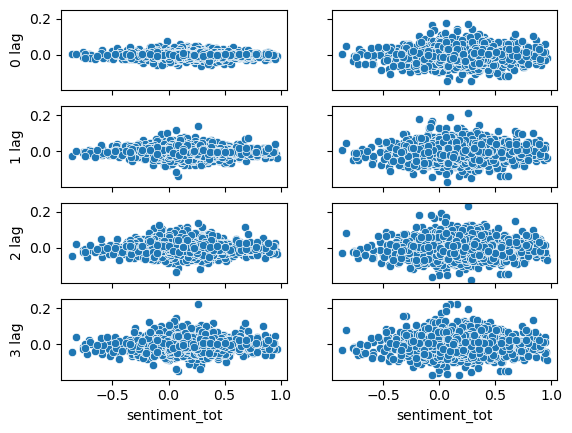

In [82]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
plt.sca(ax[0][0])
for i in range(0, 8):
    plt.sca(ax[i%4][i//4])
    sns.scatterplot(x= df_final['sentiment_tot'], y = df_final[str(i)+' lag'])  

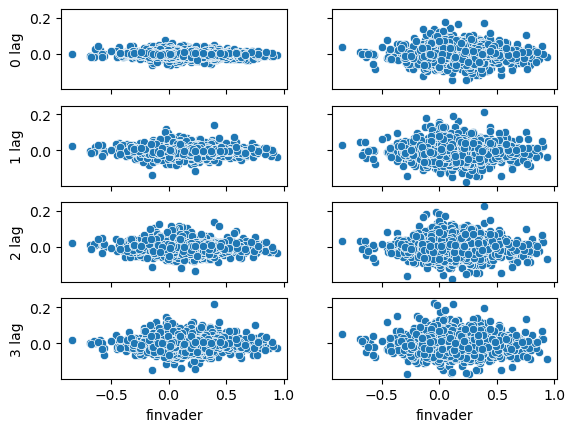

In [83]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
plt.sca(ax[0][0])
for i in range(0, 8):
    plt.sca(ax[i%4][i//4])
    sns.scatterplot(x= df_final['finvader'], y = df_final[str(i)+' lag'])  

In [84]:
correlators = []
for i in range(0, 8):
    correlators.append(df_all[['finvader', str(i) + ' lag']].corr(method = 'pearson'))
correlators

[          finvader     0 lag
 finvader  1.000000 -0.080303
 0 lag    -0.080303  1.000000,
           finvader     1 lag
 finvader  1.000000 -0.054053
 1 lag    -0.054053  1.000000,
           finvader     2 lag
 finvader  1.000000 -0.044767
 2 lag    -0.044767  1.000000,
           finvader     3 lag
 finvader  1.000000 -0.011555
 3 lag    -0.011555  1.000000,
           finvader    4 lag
 finvader   1.00000 -0.03525
 4 lag     -0.03525  1.00000,
           finvader    5 lag
 finvader   1.00000 -0.04382
 5 lag     -0.04382  1.00000,
           finvader     6 lag
 finvader  1.000000 -0.040981
 6 lag    -0.040981  1.000000,
           finvader    7 lag
 finvader   1.00000 -0.04418
 7 lag     -0.04418  1.00000]

In [86]:
correlators = []
for i in range(0, 8):
    correlators.append(df_all[['sentiment_tot', str(i) + ' lag']].corr(method = 'pearson'))
correlators

[               sentiment_tot     0 lag
 sentiment_tot       1.000000 -0.027685
 0 lag              -0.027685  1.000000,
                sentiment_tot     1 lag
 sentiment_tot       1.000000 -0.023986
 1 lag              -0.023986  1.000000,
                sentiment_tot     2 lag
 sentiment_tot       1.000000 -0.003248
 2 lag              -0.003248  1.000000,
                sentiment_tot     3 lag
 sentiment_tot       1.000000  0.024727
 3 lag               0.024727  1.000000,
                sentiment_tot    4 lag
 sentiment_tot        1.00000  0.00463
 4 lag                0.00463  1.00000,
                sentiment_tot     5 lag
 sentiment_tot       1.000000 -0.013675
 5 lag              -0.013675  1.000000,
                sentiment_tot     6 lag
 sentiment_tot       1.000000 -0.021663
 6 lag              -0.021663  1.000000,
                sentiment_tot     7 lag
 sentiment_tot       1.000000 -0.017826
 7 lag              -0.017826  1.000000]